In [2]:
import pandas_gbq as pbq
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import base64
from pathlib import Path
import warnings

from appscript import app, k
from mactypes import Alias
from pathlib import Path


font_style = 'Helvetica'
    
mpl.rcParams['font.family'] = font_style
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.titleweight"] = "bold"

try:
    plt.style.use(r'C:\Users\KamilcS\OneDrive - Universal Music Group\projects\matplotlibrc')
except:
    plt.style.use('/Users/KamilcS/Library/CloudStorage/OneDrive-UniversalMusicGroup/projects/matplotlibrc')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

palette = json.loads(open("../palette.json").read())
report_date = datetime.now().strftime('%Y-%m-%d')


# CHRIS TOMLIN
# Emmanuel: Christmas Songs of Worship (Deluxe)
# 9075957 6041
#

In [3]:
album_dict = json.loads(open('/Users/KamilcS/Library/CloudStorage/OneDrive-UniversalMusicGroup/projects/ALBUM_DATA.json').read())
# for k,v in album_dict.items():
#     print(k)
#     print('\t', tuple(v['track_list']))


In [13]:
def pull_down_data(albums_dict, year):
    query = open('./queries/w1_album_consumption_tracks_list.sql').read()

    dfs_list = []

    for k,v in albums_dict.items():
        master_album = k
        r2_project_number = v['r2_project_number']
        tracks_list = tuple(v['track_list'])

        query_formatted = query.format(
            r2_project_number= r2_project_number,
            tracks_list = tracks_list,
            start_date = f'{year}-10-01',
            end_date = f'{year}-12-31'
        )

        print(f'pulling: {master_album}\t {year}')

        df = pbq.read_gbq(query_formatted, project_id='umg-us')
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        df['master_album'] = master_album
        dfs_list.append(df)

    
    # AFTER LOOP IS DONE, DO BELOW

    df = pd.concat(dfs_list)

    df['album_adjusted_units'] = np.where(
        df['usage_group'].str.contains('Streaming (Premium)', regex=False), df['units'].div(1250), 
            np.where(df['usage_group'].str.contains('Streaming (Free)', regex=False), df['units'].div(3750),
                np.where(
                    df['product_type'].str.contains('Video', regex=False), df['units'].div(3750),
                        np.where(
                            df['usage_group'].str.contains('Download (Track)', regex=False), df['units'].div(10), df['units']
                        )
                    )
                )
            )

    df['raw_stream_units'] = np.where(
        df['usage_group'].str.contains('Streaming', regex=False), df['units'], 0
    )


    df['product_type'] = np.where(
        df['product_type'] == 'Track', 'Audio', df['product_type']

    )

    df = df[(df.units != 0) & (df.account != 'recochoku')]

    df['year'] = df['transaction_date'].dt.year
    df['month'] = df['transaction_date'].dt.month
    df['day'] = df['transaction_date'].dt.day
    df['month_day'] = df['transaction_date'].dt.strftime('%b-%d')
    

    # FIX FOR AMY GRANT ALBUM, STRAND APOSTROPHES
    df['master_track'] = df['master_track'].str.replace("’", "'")


    return df


### KEEP FOR GENRATING
######################
years_list = [2019, 2020, 2021, 2022]
# df = pd.concat([pull_down_data(album_dict['Chris Tomlin'], year) for year in years_list])
# df.to_pickle('./data/chris_tomlin_christmas_albums.pkl')
######################
### KEEP FOR GENRATING

# df = pd.read_pickle('./data/chris_tomlin_christmas_albums.pkl')
df = pd.read_pickle('./data/amy_grant_christmas_albums.pkl')



# df = df[(df.units != 0) & (df.account != 'recochoku')]
# _2019 = pd.date_range('2019-10-01', '2019-12-31').to_series()
# _2020 = pd.date_range('2020-10-01', '2020-12-31').to_series()
# _2021 = pd.date_range('2021-10-01', '2021-12-31').to_series()
# _2022 = pd.date_range('2022-10-01', '2022-12-31').to_series()
# reindex_dates = pd.concat([_2019, _2020, _2021, _2022])

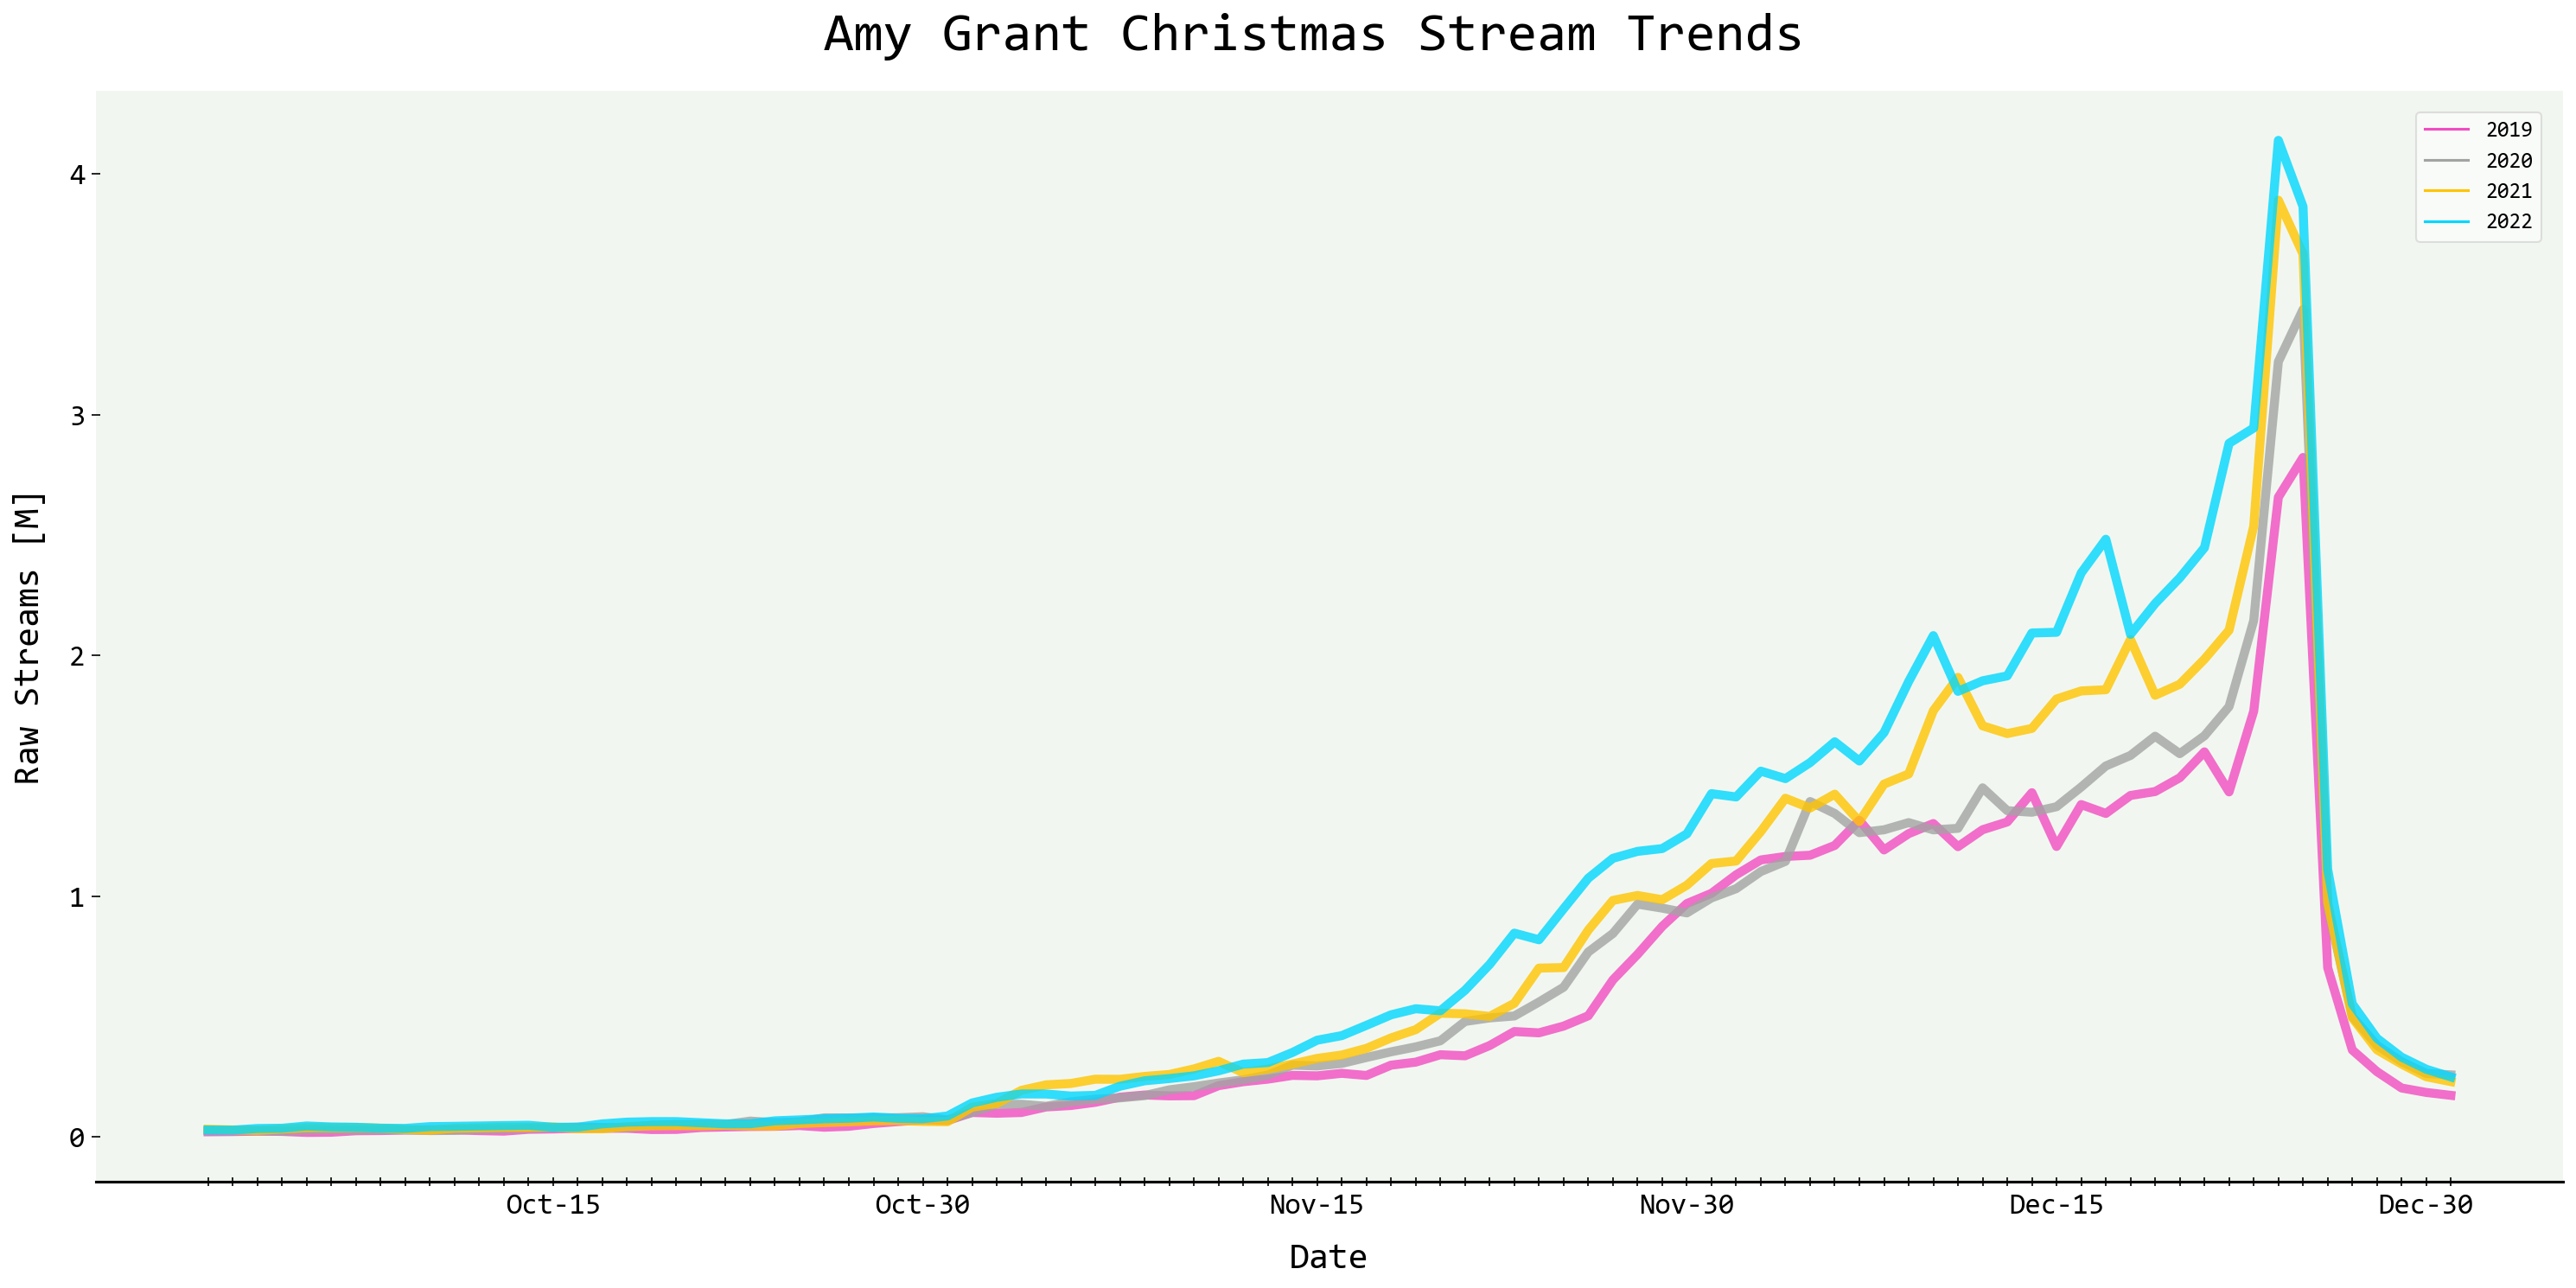

In [14]:

def plot_executive(df):
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (20,10), dpi=150)
    title_string = f'{df.master_artist.unique()[0]} Christmas Stream Trends'
    out_path_image = './outputs/' + title_string.lower().replace(' ', '_') + '.png'
    out_path_html = out_path_image.replace('.png', '.html')

    df = df.groupby(['transaction_date', 'month_day']).raw_stream_units.sum().reset_index().sort_values('transaction_date')

    sns.lineplot(
        data=df, 
        ax=ax,
        x=df['month_day'],
        y=df['raw_stream_units'].div(1000000),
        hue=df["transaction_date"].dt.year,
        ci=None,
        palette={i[0]: i[1] for i in list(zip(years_list, sns.color_palette('bright').as_hex()[-4:]))},
        lw=5,
        alpha=.8
    ).set(
        xlabel = 'Date',
        ylabel = 'Raw Streams [M]',
    )
    
    sns.despine(left=True)

    fig.suptitle(title_string, size = 30, weight="bold", y=0.99, x=0.51)
    plt.tight_layout(pad=1.2)
    ax.set_facecolor('#f1f7f0')
    ax.legend(borderaxespad=1, title='')
    plt.tick_params(axis='both', which='major', labelsize=16)

    # Remove Clustered Axis Labels
    for label in ax.xaxis.get_ticklabels():
        if not ("15" in label.get_text() or  "30" in label.get_text()):
            label.set_visible(False)

    fig.savefig(out_path_image)
    handles, labels = plt.gca().get_legend_handles_labels()
    return out_path_image, out_path_html, title_string

out_path_image_1, out_path_html, title_string = plot_executive(df)

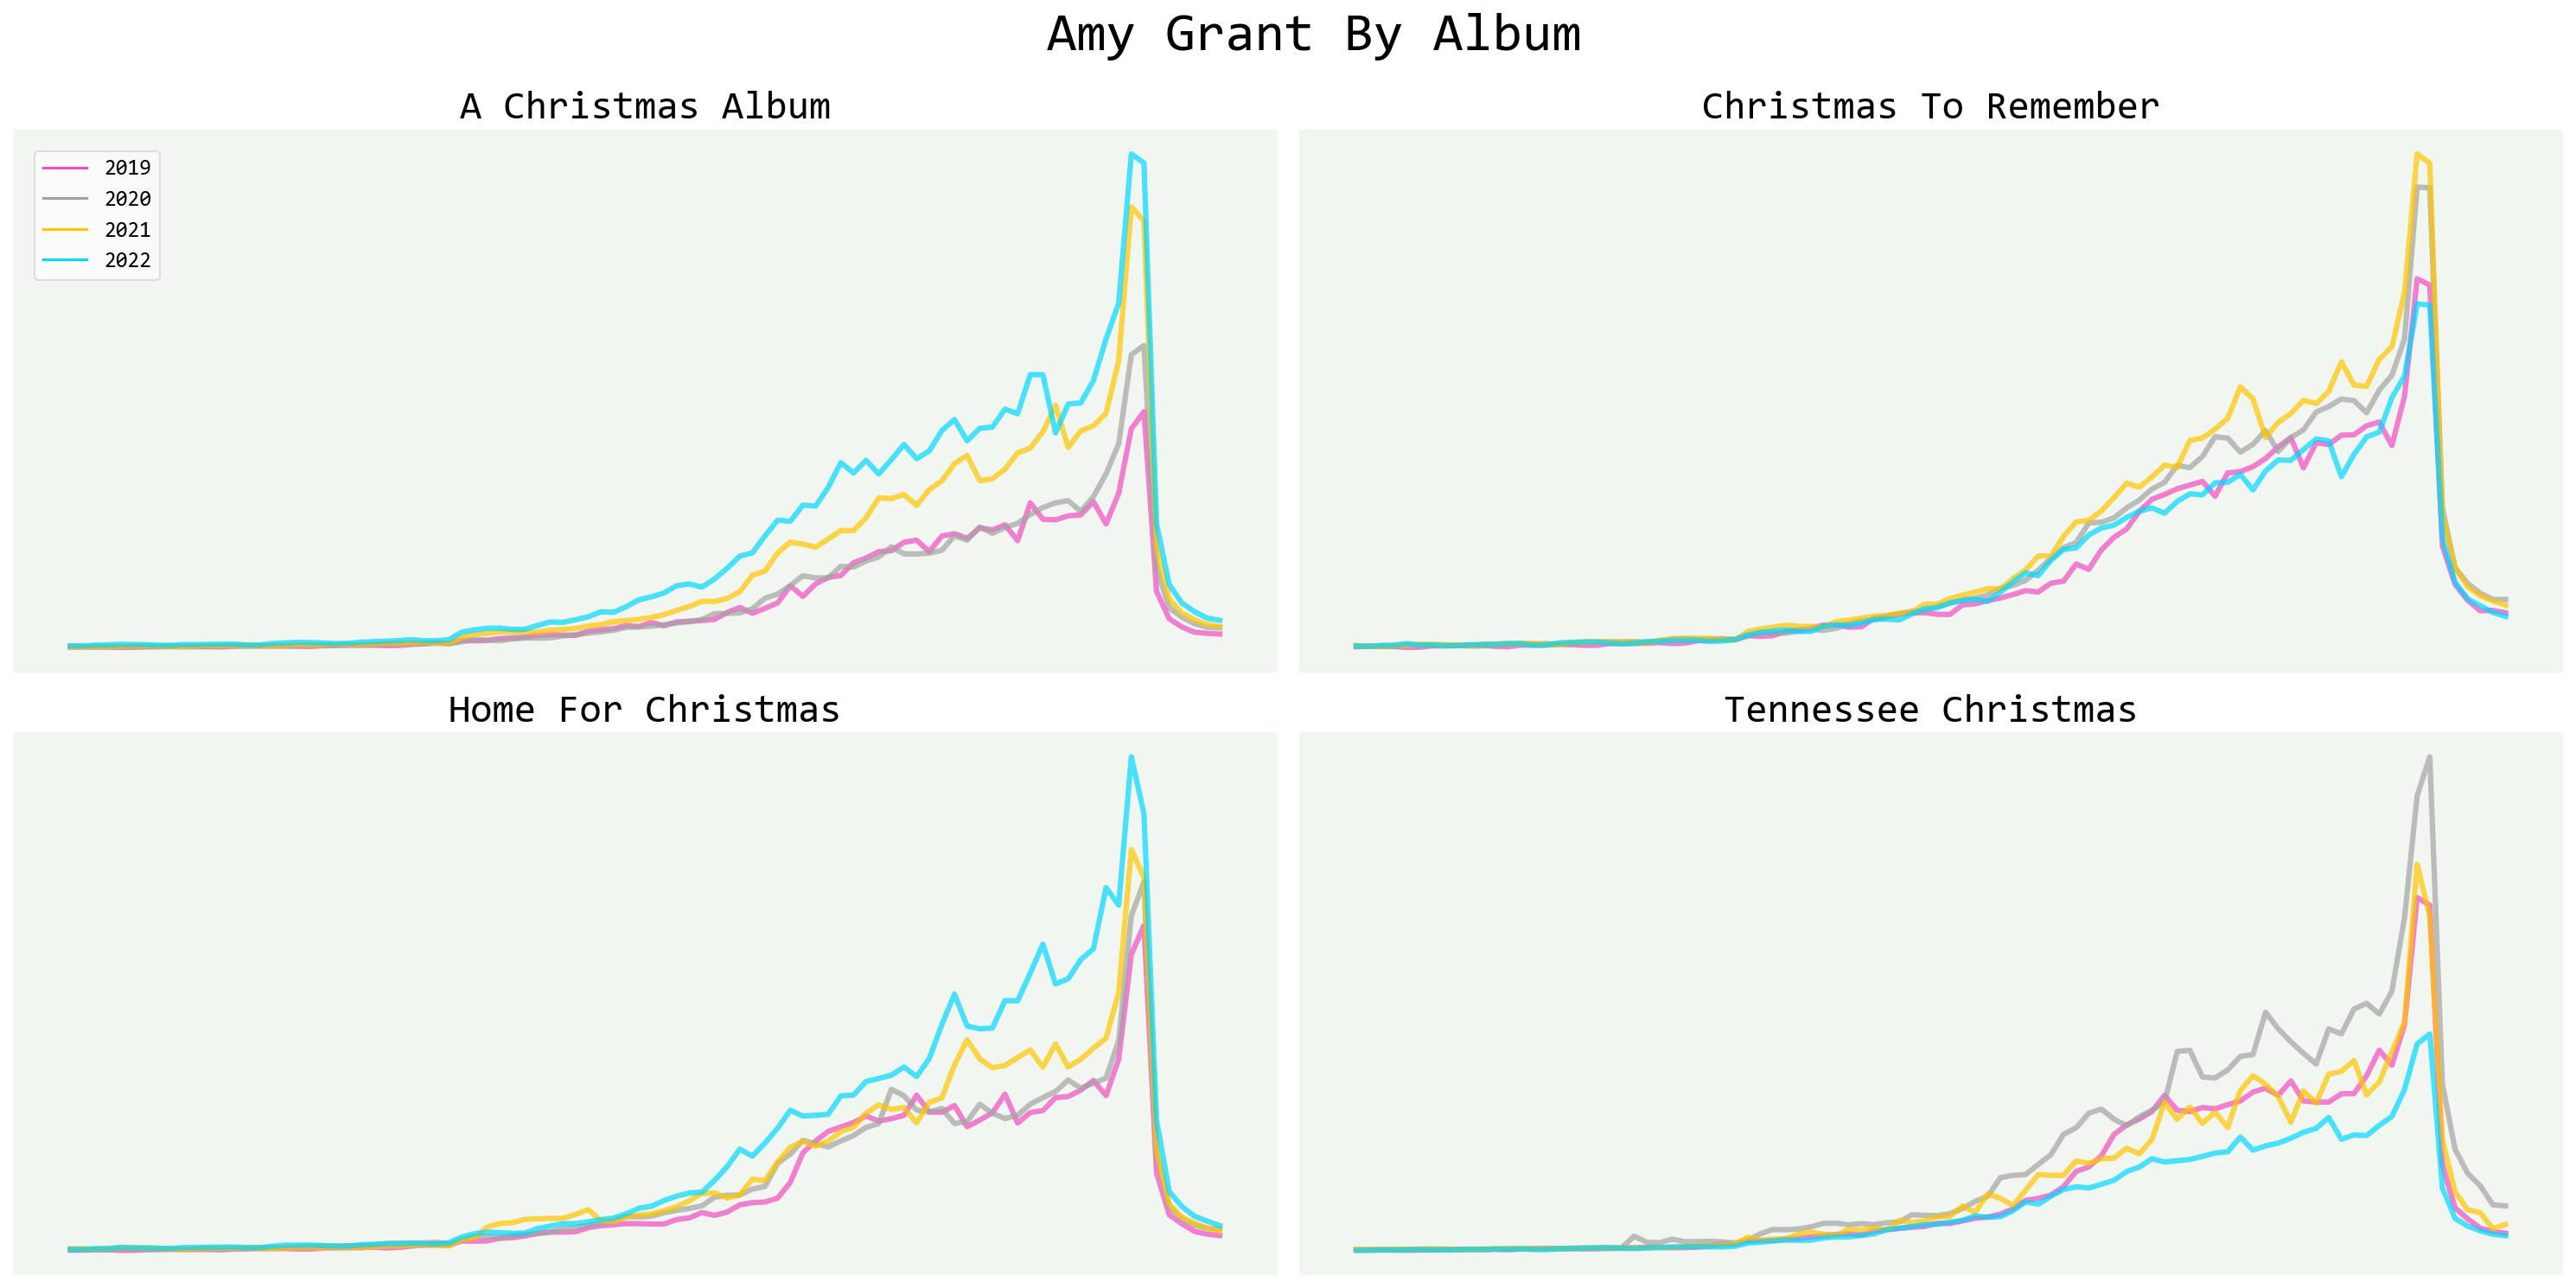

In [15]:
def plot_albums(df):

    # palette_dict = 

    artist = df.master_artist.unique()[0]
    albums = df.master_album.unique()
    album_count = len(albums)

    fig, axes = plt.subplots(nrows=2,ncols=2,figsize = (20,10), dpi=150, sharex=True, sharey=False)

    title_string = f'{artist} By Album'
    out_path_image_1 = './outputs/' + title_string.lower().replace(' ', '_') + '.png'

    album_groups = df.groupby('master_album')
    group_keys = list(album_groups.groups.keys())

    for i, (ax, grp_name ) in enumerate(list(zip(axes.flatten(), group_keys))):
        df_grp = album_groups.get_group(grp_name)
        df_grp = df_grp.groupby(['transaction_date', 'month_day']).raw_stream_units.sum().reset_index().sort_values('transaction_date')

        sns.lineplot(
            data=df_grp, 
            ax=ax,
            x=df_grp['month_day'],
            y=df_grp['raw_stream_units'].div(1000000),
            hue=df_grp["transaction_date"].dt.year,
            ci=None,
            # palette=list(sns.color_palette("Set2"))[::-1][:4]
            palette = {i[0]: i[1] for i in list(zip(years_list, sns.color_palette('bright').as_hex()[-4:]))},
            lw=3,
            alpha=.7
        ).set(
            xlabel = None,
            ylabel = None,
            title = grp_name,
            
        )

        ax.legend(borderaxespad=1, title='')

        if i != 0:
            ax.get_legend().remove()

        
 
        # Remove Clustered Axis Labels
        for label in ax.xaxis.get_ticklabels():
            if not ("15" in label.get_text() or  "30" in label.get_text()):
                label.set_visible(False)
            else:
                print(label.get_text())

        ax.set_facecolor('#f1f7f0')
        ax.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
        



    sns.despine(left=True, bottom=True)
    fig.suptitle(title_string, size = 30, weight="bold", y=0.99, x=0.51)
    plt.tight_layout(pad=1.2)
    fig.savefig(out_path_image_1)

    return out_path_image_1, title_string

out_path_image_1, title_string = plot_albums(df)

# plot_albums(df)

In [ ]:
def raw_stream_units_table(df):
    df = df[df['usage_group'].str.contains('Streaming')]

    df = df.pivot_table(index='master_album', columns=['product_type', 'account'], values='raw_stream_units', aggfunc='sum')


    df['TOTAL'] = df.sum(1)





    return df.sort_values('TOTAL').fillna(0).astype(int)


raw_stream_units_table(df)

In [ ]:
## TABLE 1 (RAW STREAM)
def raw_stream_units_table(df):
    df = df[df['usage_group'].str.contains('Streaming')]
    df_list = []
    sub_totals = []
    album_groups = df.groupby(['master_album'])
    for grp in album_groups.groups.keys():

        df1 = album_groups.get_group(grp)
        df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='raw_stream_units', aggfunc='sum')
        df2['TOTAL'] = df2.sum(1)
        df2 = df2.sort_values(['master_album', 'TOTAL'], ascending=False, axis=0)
        grp_subtotal = df2.sum()
        df2.loc[(grp, f'SUB TOTAL'), :] = grp_subtotal
        df_list.append(df2)
        sub_totals.append(grp_subtotal)

    final_df = pd.concat(df_list, axis=0).fillna(0)
    final_df.loc[('ALL ALBUM', 'GRAND TOTAL'), :] = sum(sub_totals)
    reset_df = final_df.reset_index()
    return final_df.astype(int), reset_df[reset_df['master_track'].str.contains('TOTAL')].index



## TABLE 2 (TRACK DOWNLOADS)
def track_download_table(df):
    df = df[df['usage_group'].str.contains('Track')]
    df_list = []
    sub_totals = []
    # total_indexes = []
    album_groups = df.groupby(['master_album'])
    for grp in album_groups.groups.keys():

        df1 = album_groups.get_group(grp)
        df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='units', aggfunc='sum')
        # display(df2.head())
        df2['TOTAL'] = df2.sum(1)
        df2 = df2.sort_values(['master_album', 'TOTAL'], ascending=False, axis=0)
        grp_subtotal = df2.sum()
        df2.loc[(grp, f'SUB TOTAL'), :] = grp_subtotal
        # display(df2.head())
        df_list.append(df2)
        sub_totals.append(grp_subtotal)

    final_df = pd.concat(df_list, axis=0).fillna(0)
    final_df.loc[('ALL ALBUM', 'GRAND TOTAL'), :] = sum(sub_totals)
    reset_df = final_df.reset_index()

    return final_df.fillna(0).astype(int), reset_df[reset_df['master_track'].str.contains('TOTAL')].index

## TABLE 3 (TOTAL CONSUMPTION)
def total_consumption_table(df):
    # df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='units', aggfunc='sum')
    df1 = df.pivot_table(index=['master_album'], values='album_adjusted_units', aggfunc='sum')

    df1 = df1.sort_values('album_adjusted_units', ascending=False)
    df1.loc['GRAND TOTAL', :] = df1.sum(0)

    print(df1.shape)

    return df1.astype(int)

df_raw_streams, df_raw_streams_indexes = raw_stream_units_table(df)

df_track_downloads, df_track_downloads_indexes = track_download_table(df)

df_total_consumption = total_consumption_table(df)

In [ ]:
df_raw_streams

In [ ]:
data_uri = base64.b64encode(open(str(out_path_image), 'rb').read()).decode('utf-8')
img_tag = '<img style="margin-top: 80px;" src="data:image/png;base64,{0}">'.format(data_uri)

html_string = '''
<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=0.5" /> 
<style> 
  #centered {{clear:both; margin: auto; zoom: 75%;}}
  html {{font-family:consolas; margin: auto; margin-bottom: 100px; margin-bottom: 100px;}}
  png {{margin-top: 80px;}}
  tables1, tables2, tables3 {{ display: inline-block; padding: 20px; border-collapse: collapse; margin: 0;}}

  h2 {{ font-size: 30pt; text-align:left;}}
  thead {{
    font-size: 20pt;text-align:center; vertical-align: center;padding: 10px; border-bottom:1px solid black; color: black; background-color: #fafaf0; margin: 0;
    }}
  th {{
    font-size: 18pt; text-align:center; vertical-align: center;padding: 10px; border-bottom:1px solid black; color: black; background-color: #f1f7f0; 
    padding-left: 100px;margin: 0;
    }}
  td {{
    font-size: 15pt;text-align:right; vertical-align: center; padding: 10px; border-bottom:1px solid black; background-color: white;
    padding-left: 100px;margin: 0;
    }}

    .blank, level0, level1 {{background-color: #ffffff;}}
    

    .level0, row0 {{background-color: #cee0cc}}
    {borders}


    
</style>
</head>
  <body id="centered">
    <center><png>{image}</png></center>
  <hr>  
  <center>
    <tables1 style="margin-top: 20px;">
    <center><h2>Raw Streams</h2></center>
    <center>{table1}</center>
    </tables1>
    <tables2 style="margin-top: 20px;">
    <center><h2>Track Downloads</h2></center>
    <center>{table2}</center>
    </tables2>

    <tables3 style="margin-top: 20px;">
    <center><h2>Total Consumption</h2></center>
    <center>{table3}</center>
    </tables3>

  </center>
  </body>
</html>
'''.format(
        image=img_tag,
        table1=df_raw_streams.style.format(precision=0, na_rep=0, thousands=",").to_html(),
        table2=df_track_downloads.style.format(precision=0, na_rep=0, thousands=",").to_html(),
        table3=df_total_consumption.style.format(precision=0, na_rep=0, thousands=",").to_html(),

        borders = ''.join(
            '.row{i} {{ border-bottom: 3px solid #455943;}}\n'.format(i=num) for num in df_raw_streams_indexes

            )
        )




with open(out_path_html, 'w') as f:
    f.write(html_string)

In [ ]:
from appscript import app, k
from mactypes import Alias
from pathlib import Path

def create_message_with_attachment():
    subject = f'{title_string}'
    body = f'<br>\n{html_string}' \
        .replace('padding-left: 100px', 'padding-left: 20px') \
        .replace('font-size: 18pt', 'font-size: 12pt') \
        .replace('font-size: 16pt', 'font-size: 10pt') \
        .replace('padding: 10px', 'padding: 2px') \
        .replace('<hr>', '') \
        .replace('<center>', '') \
        .replace('</center>', '') \
        .replace('font-size: 30pt;', 'font-size: 20pt;') 
    to_recip = []

    msg = Message(subject=subject, body=body, to_recip=to_recip, cc_recip=['david.sylvester@umusic.com'])

    # attach file
    p = str(out_path_html)
    msg.add_attachment(p)

    msg.show()

class Outlook(object):
    def __init__(self):
        self.client = app('Microsoft Outlook')

class Message(object):
    def __init__(self, parent=None, subject='', body='', to_recip=[], cc_recip=[], show_=True):

        if parent is None: parent = Outlook()
        client = parent.client

        self.msg = client.make(
            new=k.outgoing_message,
            with_properties={k.subject: subject, k.content: body})

        self.add_recipients(emails=to_recip, type_='to')
        self.add_recipients(emails=cc_recip, type_='cc')

        if show_: self.show()

    def show(self):
        self.msg.open()
        self.msg.activate()

    def add_attachment(self, p):
        # p is a Path() obj, could also pass string

        p = Alias(str(p)) # convert string/path obj to POSIX/mactypes path

        attach = self.msg.make(new=k.attachment, with_properties={k.file: p})

    def add_recipients(self, emails, type_='to'):
        if not isinstance(emails, list): emails = [emails]
        for email in emails:
            self.add_recipient(email=email, type_=type_)

    def add_recipient(self, email, type_='to'):
        msg = self.msg

        if type_ == 'to':
            recipient = k.to_recipient
        elif type_ == 'cc':
            recipient = k.cc_recipient

        msg.make(new=recipient, with_properties={k.email_address: {k.address: email}})

In [ ]:
create_message_with_attachment()